# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$
* `WoldModelVariationalFixedBeta`: VI with parameters $\alpha$ only ($\beta$ are fixed hyper-parameters)

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
import itertools
import torch

from tsvar.simulate import GrangerBuscaSimulator
from tsvar.models import WoldModelVariational, WoldModelVariationalFixedBeta

---

## Generate small toy example dataset

Define model parameters

In [3]:
dim = 3

baseline = np.array([0.1, 0.1, 0.2])

# adjacency[i,j] = magnitude of influence from i to j
adjacency = np.array([
    [0.3, 0.8, 0.1],
    [0.2, 0.3, 0.1],
    [0.2, 0.1, 0.0]
])

beta = 1.0

end_time = 5e4

for i, j in itertools.product(range(dim), repeat=2):
    print(f"w({j:d} -> {i:d}) = {adjacency[j,i]:.2f}")

w(0 -> 0) = 0.30
w(1 -> 0) = 0.20
w(2 -> 0) = 0.20
w(0 -> 1) = 0.80
w(1 -> 1) = 0.30
w(2 -> 1) = 0.10
w(0 -> 2) = 0.10
w(1 -> 2) = 0.10
w(2 -> 2) = 0.00


Simulate a dataset

In [4]:
wold_sim = GrangerBuscaSimulator(mu_rates=baseline, Alpha_ba=adjacency, Beta_b=beta * np.ones((dim,)))
events = wold_sim.simulate(end_time, seed=42)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]


print('Number of events per dimension:', list(map(len, events)))
print('Total number of events:', sum(map(len, events)))
print()
print(events[0])
print()
print(events[1])
print()
print(events[2])

Number of events per dimension: [18347, 27741, 14204]
Total number of events: 60292

tensor([2.0491e+01, 2.9055e+01, 2.9225e+01,  ..., 4.9992e+04, 4.9996e+04,
        5.0000e+04])

tensor([1.8329e+01, 2.9223e+01, 3.0418e+01,  ..., 4.9996e+04, 4.9997e+04,
        4.9998e+04])

tensor([2.2043e+00, 1.5157e+01, 1.6076e+01,  ..., 4.9997e+04, 4.9999e+04,
        4.9999e+04])


---

## Test variational inference algorithm

Create model object and set the data.

In [32]:
model = WoldModelVariational(verbose=True)
model.observe(events)

Define the parameters of the prior.

In [35]:
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

Fit the model.

In [36]:
model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, max_iter=100, tol=1e-5)

-------------------------------------------------- 0
Alpha posterior mean:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
Z[0] posterior probabilities
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
-------------------------------------------------- 1
Alpha posterior mean:
[[0.09 0.14 0.07]
 [0.19 0.3  0.14]
 [0.16 0.23 0.12]
 [0.21 0.3  0.15]]
Z posterior probabilities
[[0.24977 0.25012 0.25001 0.2501 ]
 [0.25044 0.25079 0.25069 0.24808]
 [0.24977 0.25012 0.25001 0.2501 ]
 ...
 [0.24995 0.25031 0.2502  0.24954]
 [0.24977 0.25012 0.25001 0.2501 ]
 [0.25099 0.25134 0.25123 0.24644]]
-------------------------------------------------- 2
Alpha posterior mean:
[[0.09 0.14 0.07]
 [0.38 0.6  0.27]
 [0.27 0.39 0.2 ]
 [0.45 0.63 0.31]]
Z posterior probabilities
[[0.25013 0.25009 0.24981 0.24998]
 [0.25013 0.25009 0.24981 0.24998]
 [0.25013 0.25009 0.24981 0.24998]
 ...
 [0.25013 0.25009 0.24981 0.2

Alpha posterior mean:
[[0.09 0.14 0.07]
 [1.18 1.76 0.87]
 [0.83 1.24 0.6 ]
 [1.34 2.   0.96]]
Z posterior probabilities
[[0.24631 0.25222 0.25051 0.25096]
 [0.24631 0.25222 0.25051 0.25096]
 [0.24631 0.25222 0.25051 0.25096]
 ...
 [0.24631 0.25222 0.25051 0.25096]
 [0.24631 0.25222 0.25051 0.25096]
 [0.24631 0.25222 0.25051 0.25096]]
-------------------------------------------------- 23
Alpha posterior mean:
[[0.09 0.14 0.07]
 [1.19 1.79 0.89]
 [0.85 1.26 0.61]
 [1.36 2.03 0.97]]
Z posterior probabilities
[[0.246   0.25236 0.25059 0.25105]
 [0.246   0.25236 0.25059 0.25105]
 [0.246   0.25236 0.25059 0.25105]
 ...
 [0.246   0.25236 0.25059 0.25105]
 [0.246   0.25236 0.25059 0.25105]
 [0.246   0.25236 0.25059 0.25105]]
-------------------------------------------------- 24
Alpha posterior mean:
[[0.09 0.14 0.07]
 [1.21 1.81 0.9 ]
 [0.86 1.28 0.62]
 [1.37 2.05 0.98]]
Z posterior probabilities
[[0.24569 0.25249 0.25068 0.25114]
 [0.24569 0.25249 0.25068 0.25114]
 [0.24775 0.25461 0.24439 0

Z posterior probabilities
[[0.23924 0.25524 0.25239 0.25313]
 [0.23924 0.25524 0.25239 0.25313]
 [0.23928 0.25528 0.25226 0.25318]
 ...
 [0.23924 0.25524 0.25239 0.25313]
 [0.23924 0.25524 0.25239 0.25313]
 [0.23924 0.25524 0.25239 0.25313]]
-------------------------------------------------- 44
Alpha posterior mean:
[[0.09 0.13 0.07]
 [1.4  2.16 1.06]
 [1.03 1.53 0.74]
 [1.62 2.43 1.14]]
Z posterior probabilities
[[0.23889 0.25539 0.25248 0.25323]
 [0.23889 0.25539 0.25248 0.25323]
 [0.23891 0.25541 0.25243 0.25325]
 ...
 [0.23889 0.25539 0.25248 0.25323]
 [0.23889 0.25539 0.25248 0.25323]
 [0.23889 0.25539 0.25248 0.25323]]
-------------------------------------------------- 45
Alpha posterior mean:
[[0.09 0.13 0.07]
 [1.41 2.17 1.07]
 [1.04 1.54 0.74]
 [1.63 2.44 1.15]]
Z posterior probabilities
[[0.23854 0.25555 0.25258 0.25333]
 [0.23854 0.25555 0.25258 0.25333]
 [0.23855 0.25555 0.25257 0.25333]
 ...
 [0.23854 0.25555 0.25258 0.25333]
 [0.23854 0.25555 0.25258 0.25333]
 [0.23854 0.

Alpha posterior mean:
[[0.08 0.13 0.07]
 [1.54 2.39 1.16]
 [1.14 1.69 0.82]
 [1.76 2.66 1.26]]
Z posterior probabilities
[[0.23114 0.25869 0.25476 0.25541]
 [0.23114 0.25869 0.25476 0.25541]
 [0.23114 0.25869 0.25476 0.25541]
 ...
 [0.23114 0.25869 0.25476 0.25541]
 [0.23114 0.25869 0.25476 0.25541]
 [0.23114 0.25869 0.25476 0.25541]]
-------------------------------------------------- 67
Alpha posterior mean:
[[0.08 0.13 0.07]
 [1.54 2.39 1.17]
 [1.15 1.7  0.82]
 [1.76 2.67 1.26]]
Z posterior probabilities
[[0.23079 0.25883 0.25486 0.25551]
 [0.23079 0.25883 0.25486 0.25551]
 [0.23079 0.25883 0.25486 0.25551]
 ...
 [0.23079 0.25883 0.25486 0.25551]
 [0.23079 0.25883 0.25486 0.25551]
 [0.23079 0.25883 0.25486 0.25551]]
-------------------------------------------------- 68
Alpha posterior mean:
[[0.08 0.13 0.07]
 [1.55 2.4  1.17]
 [1.15 1.7  0.82]
 [1.76 2.68 1.27]]
Z posterior probabilities
[[0.23043 0.25898 0.25497 0.25562]
 [0.23043 0.25898 0.25497 0.25562]
 [0.23043 0.25898 0.25497 0

Alpha posterior mean:
[[0.08 0.13 0.06]
 [1.64 2.54 1.22]
 [1.23 1.8  0.87]
 [1.83 2.83 1.33]]
Z posterior probabilities
[[0.22307 0.26208 0.25714 0.25771]
 [0.22307 0.26208 0.25714 0.25771]
 [0.22307 0.26208 0.25714 0.25771]
 ...
 [0.22307 0.26208 0.25714 0.25771]
 [0.22307 0.26208 0.25714 0.25771]
 [0.22307 0.26208 0.25714 0.25771]]
-------------------------------------------------- 90
Alpha posterior mean:
[[0.08 0.13 0.06]
 [1.65 2.55 1.22]
 [1.23 1.8  0.87]
 [1.83 2.84 1.34]]
Z posterior probabilities
[[0.22273 0.26222 0.25724 0.25781]
 [0.22273 0.26222 0.25724 0.25781]
 [0.22273 0.26222 0.25724 0.25781]
 ...
 [0.22273 0.26222 0.25724 0.25781]
 [0.22273 0.26222 0.25724 0.25781]
 [0.22273 0.26222 0.25724 0.25781]]
-------------------------------------------------- 91
Alpha posterior mean:
[[0.08 0.13 0.06]
 [1.65 2.55 1.23]
 [1.23 1.8  0.87]
 [1.83 2.84 1.34]]
Z posterior probabilities
[[0.22238 0.26237 0.25734 0.25791]
 [0.22238 0.26237 0.25734 0.25791]
 [0.22238 0.26237 0.25734 0

In [37]:
alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)
baseline_hat = alpha_hat_mean[0,:]
adjacency_hat = alpha_hat_mean[1:,:]
beta_hat = np.round(model._br_po / (model._bs_po - 1), 2) - 1

print('Baseline:')
print('---------')
print('Ground truth:')
print(baseline)
print('Estimated:')
print(baseline_hat)
print()

print('Adjacency:')
print('---------')
print('Ground truth:')
print(adjacency)
print('Estimated:')
print(adjacency_hat)
print()

print('Beta:')
print('-----')
print('Ground truth:')
print(beta * np.ones((dim, dim)))
print('Estimated:')
print(beta_hat)

Baseline:
---------
Ground truth:
[0.1 0.1 0.2]
Estimated:
[0.08 0.13 0.06]

Adjacency:
---------
Ground truth:
[[0.3 0.8 0.1]
 [0.2 0.3 0.1]
 [0.2 0.1 0. ]]
Estimated:
[[1.69 2.6  1.25]
 [1.25 1.84 0.89]
 [1.85 2.89 1.36]]

Beta:
-----
Ground truth:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
Estimated:
[[16.43 16.93 15.57]
 [12.19 11.76 10.97]
 [18.46 19.48 17.58]]


*Debugging stuff*

In [11]:
as_pr=model._as_pr
ar_pr=model._ar_pr
zp_po=model._zp_po
bs_po=model._bs_po
br_po=model._br_po
dt_ikj=model.dt_ikj
delta_ikj=model.delta_ikj
valid_mask_ikj=model.valid_mask_ikj

as_po=model._as_po
ar_po=model._ar_po

self = model

In [25]:
import scipy.special as sc

dim = as_pr.shape[1]
as_po = np.zeros_like(as_pr)  # Alpha posterior shape, to return
ar_po = np.zeros_like(as_pr)  # Alpha posterior rate, to return

i = 0

as_po[:, i] = as_pr[:, i] + zp_po[i].sum(axis=0)
D_i_kj = (valid_mask_ikj[i][:, 1:] * dt_ikj[i][:, np.newaxis] *
          ((bs_po[:, i] / br_po[:, i])
           * sc.gammainc(bs_po[:, i] + 1, 
                         br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20))
           / (sc.gammainc(bs_po[:, i], 
                         br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)) + 1e-10)))
ar_po[0, i] = ar_pr[0, i] + self.events[i][-1]
ar_po[1:, i] = ar_pr[1:, i] + D_i_kj.sum(axis=0)

In [21]:
br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)

array([[1.49425e+24, 1.15240e+24, 1.68348e+24],
       [1.49425e+24, 5.32979e+03, 7.26862e+03],
       [1.74491e+03, 1.07444e+03, 3.83464e+03],
       ...,
       [5.79587e+04, 5.59800e+03, 7.39231e+03],
       [6.71101e+04, 5.05162e+03, 1.16479e+05],
       [4.27405e+03, 1.13467e+05, 6.29155e+03]])

In [22]:
br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)

array([[1.49425e+24, 1.15240e+24, 1.68348e+24],
       [1.49425e+24, 5.32979e+03, 7.26862e+03],
       [1.74491e+03, 1.07444e+03, 3.83464e+03],
       ...,
       [5.79587e+04, 5.59800e+03, 7.39231e+03],
       [6.71101e+04, 5.05162e+03, 1.16479e+05],
       [4.27405e+03, 1.13467e+05, 6.29155e+03]])

In [24]:
sc.gammainc(bs_po[:, i], br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20))

array([[1., 1., 1.],
       [1., 1., 1.],
       [0., 0., 0.],
       ...,
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 1.]])

In [11]:
from tsvar.models._wold_var import _update_alpha, _update_beta

self._as_po, self._ar_po = _update_alpha(as_pr=self._as_pr,
                                         ar_pr=self._ar_pr,
                                         zp_po=self._zp_po,
                                         bs_po=self._bs_po,
                                         br_po=self._br_po,
                                         dt_ikj=self.dt_ikj,
                                         delta_ikj=self.delta_ikj,
                                         valid_mask_ikj=self.valid_mask_ikj)

self._bs_po, self._br_po = _update_beta(bs_pr=self._bs_pr,
                                        br_pr=self._br_pr,
                                        zp_po=self._zp_po,
                                        as_po=self._as_po,
                                        ar_po=self._ar_po,
                                        last_t=self.last_t,
                                        delta_ikj=self.delta_ikj,
                                        valid_mask_ikj=self.valid_mask_ikj,
                                        dt_ikj=self.dt_ikj)


In [16]:
as_pr=model._as_pr
ar_pr=model._ar_pr
zp_po=model._zp_po
bs_po=model._bs_po
br_po=model._br_po
dt_ikj=model.dt_ikj
delta_ikj=model.delta_ikj
valid_mask_ikj=model.valid_mask_ikj

as_po=model._as_po
ar_po=model._ar_po

self = model

In [62]:
import scipy.special as sc

a = np.ones_like(x) * bs_po[:, i]
x = br_po[:, i] / (delta_ikj[i][:, 1:] + 1e-20)

epi = np.zeros_like(delta_ikj[i])
epi += (sc.digamma(as_po[np.newaxis, :, i])
                - np.log(ar_po[np.newaxis, :, i]))


epi[:, 1:] -= (np.log(br_po[:, i]) 
               - sc.digamma(bs_po[:, i])
               - (valid_mask_ikj[i][:, 1:]
                  * 1e5
                  * (sc.gammainc(a + 1e-5, x) - sc.gammainc(a, x))
                  / (sc.gammainc(a, x) + 1e-20)
                 ))

epi = epi - epi.max(axis=1)[:, np.newaxis]
epi = np.exp(epi)
epi /= epi.sum(axis=1)[:, np.newaxis]

epi

array([[0.25002, 0.24999, 0.24999, 0.25   ],
       [0.25002, 0.24999, 0.24999, 0.25   ],
       [0.25518, 0.23451, 0.25515, 0.25516],
       ...,
       [0.25002, 0.24999, 0.24999, 0.25   ],
       [0.25288, 0.25285, 0.25284, 0.24143],
       [0.25002, 0.24999, 0.24999, 0.25   ]])

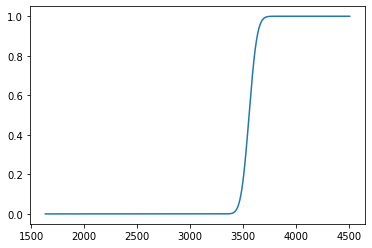

In [54]:
from matplotlib import pyplot as plt
%matplotlib inline

xx = np.linspace(1634.23296, 4504.59997, 1000)
yy = np.array([sc.gammainc(3556.25, e) for e in xx])

plt.plot(xx, yy)

In [26]:
(valid_mask_ikj[i][:, 1:]
                  * 1e5
                  * (sc.gammainc(a + 1e-5, x) - sc.gammainc(a, x))
                  / sc.gammainc(a, x))

/Users/trouleau/miniconda3/envs/var-wold/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [-0.08439,  0.     ,  0.     ],
       ...,
       [ 0.     ,      nan,  0.     ],
       [-0.37047,  0.     , -0.04624],
       [     nan,  0.     ,  0.     ]])

---

# Test variational inference algorithm *with fixed $\beta$*

Define the model object.

In [11]:
model_fixed_beta = WoldModelVariationalFixedBeta(verbose=True)
model_fixed_beta.observe(events)

Set the hyper-parameters and fit the model.

In [12]:
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

model_fixed_beta.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=100, tol=1e-5)

Explore the results.

In [13]:
alpha_hat_mean = np.round(model_fixed_beta._as_po / model_fixed_beta._ar_po, 2)
baseline_hat = alpha_hat_mean[0,:]
adjacency_hat = alpha_hat_mean[1:,:]

print('Baseline:')
print('---------')
print('Ground truth:')
print(baseline)
print('Estimated:')
print(baseline_hat)
print()

print('Adjacency:')
print('---------')
print('Ground truth:')
print(adjacency)
print('Estimated:')
print(adjacency_hat)
print()

Baseline:
---------
Ground truth:
[0.1 0.1 0.2]
Estimated:
[0.1  0.11 0.19]

Adjacency:
---------
Ground truth:
[[0.3 0.8 0.1]
 [0.2 0.3 0.1]
 [0.2 0.1 0. ]]
Estimated:
[[0.31 0.79 0.1 ]
 [0.2  0.28 0.11]
 [0.21 0.11 0.02]]

